In [1]:
!pip install -q torch_snippets
from torch_snippets import *
import torchvision.transforms as T
from torchvision.models import vgg19
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 49 kB 3.0 MB/s 
     |████████████████████████████████| 11.1 MB 20.7 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 58 kB 1.3 MB/s 
     |████████████████████████████████| 59 kB 8.2 MB/s 
     |████████████████████████████████| 948 kB 64.1 MB/s 
     |████████████████████████████████| 232 kB 72.0 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [2]:
preprocessing = T.Compose([
                           T.ToTensor(),
                           T.Normalize(mean=[0.485,0.456,0.406],
                                       std=[0.229,0.224,0.225]),
                           T.Lambda(lambda img: img.mul_(225))
])

postpressing = T.Compose([
                          T.Lambda(lambda img: img.mul_(1./255)),
                          T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                      std=[1/0.229, 1/0.224, 1/0.225])
])

In [3]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval() 
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x


vgg = vgg19_modified().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
!wget https://raw.githubusercontent.com/hoontae-jin/ML_with_Computer_Vision/main/Gogh.jpg
!wget https://raw.githubusercontent.com/hoontae-jin/ML_with_Computer_Vision/main/Bogum.jpg

--2022-05-27 09:06:38--  https://raw.githubusercontent.com/hoontae-jin/ML_with_Computer_Vision/main/Gogh.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16885 (16K) [image/jpeg]
Saving to: ‘Gogh.jpg’

Gogh.jpg            100%[===================>]  16.49K  --.-KB/s    in 0s      

2022-05-27 09:06:38 (122 MB/s) - ‘Gogh.jpg’ saved [16885/16885]

--2022-05-27 09:06:38--  https://raw.githubusercontent.com/hoontae-jin/ML_with_Computer_Vision/main/Bogum.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7850 (7.7K) [image/jpeg]
Sa

In [5]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['Gogh.jpg', 'Bogum.jpg']]
style_image, content_image = [preprocessing(img).to(device)[None] for img in imgs]

In [6]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

style_layers = [0, 5, 10, 19, 28] 
content_layers = [21]
loss_layers = style_layers + content_layers

loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

style_weights = [1000/n**2 for n in [64,128,256,512,512]] 
content_weights = [1]
weights = style_weights + content_weights

style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [7]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])
log = Report(max_iters)

In [8]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000	loss: 80759.820	(47.04s - -0.19s remaining)

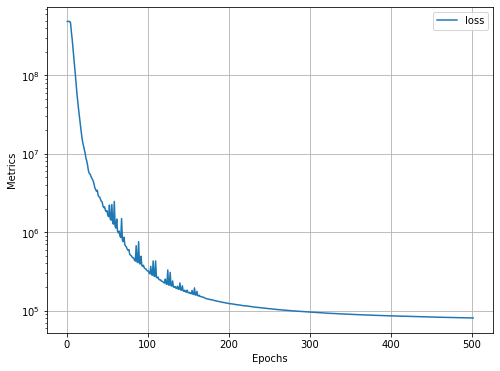

In [9]:
log.plot(log=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


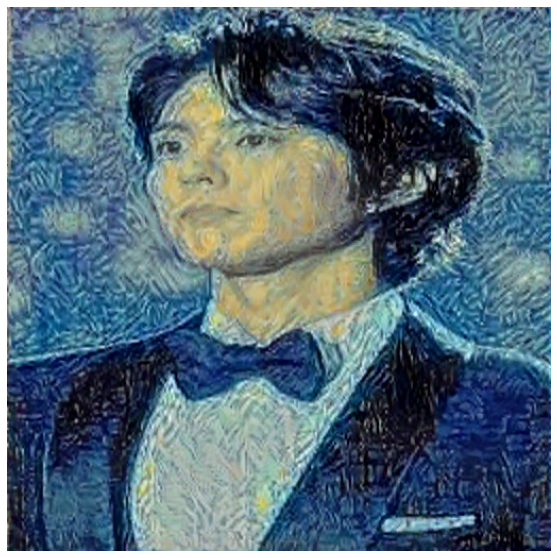

In [12]:
with torch.no_grad():
    out_img = postpressing(opt_img[0]).permute(1,2,0)
show(out_img)